In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import notebook

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# plt.style.use(["seaborn-darkgrid"])
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.family"] = "DejaVu Sans"

RANDOM_STATE = 17


In [2]:
PATH_TO_SAMSUNG_TRAIN_DATA = r"UCI HAR Dataset\train"
PATH_TO_SAMSUNG_TEST_DATA = r"UCI HAR Dataset\test"

In [3]:
X_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_TRAIN_DATA, "X_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_TRAIN_DATA, "y_train.txt")).astype(
    int
)

X_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_TEST_DATA, "X_test.txt"))
y_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_TEST_DATA, "y_test.txt")).astype(int)


In [4]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7352, 561) (7352,)
(2947, 561) (2947,)


In [5]:
y_labels_conversion = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING",
}

In [6]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

print(X.shape, y.shape)
print(X.dtype, y.dtype)

(10299, 561) (10299,)
float64 int32


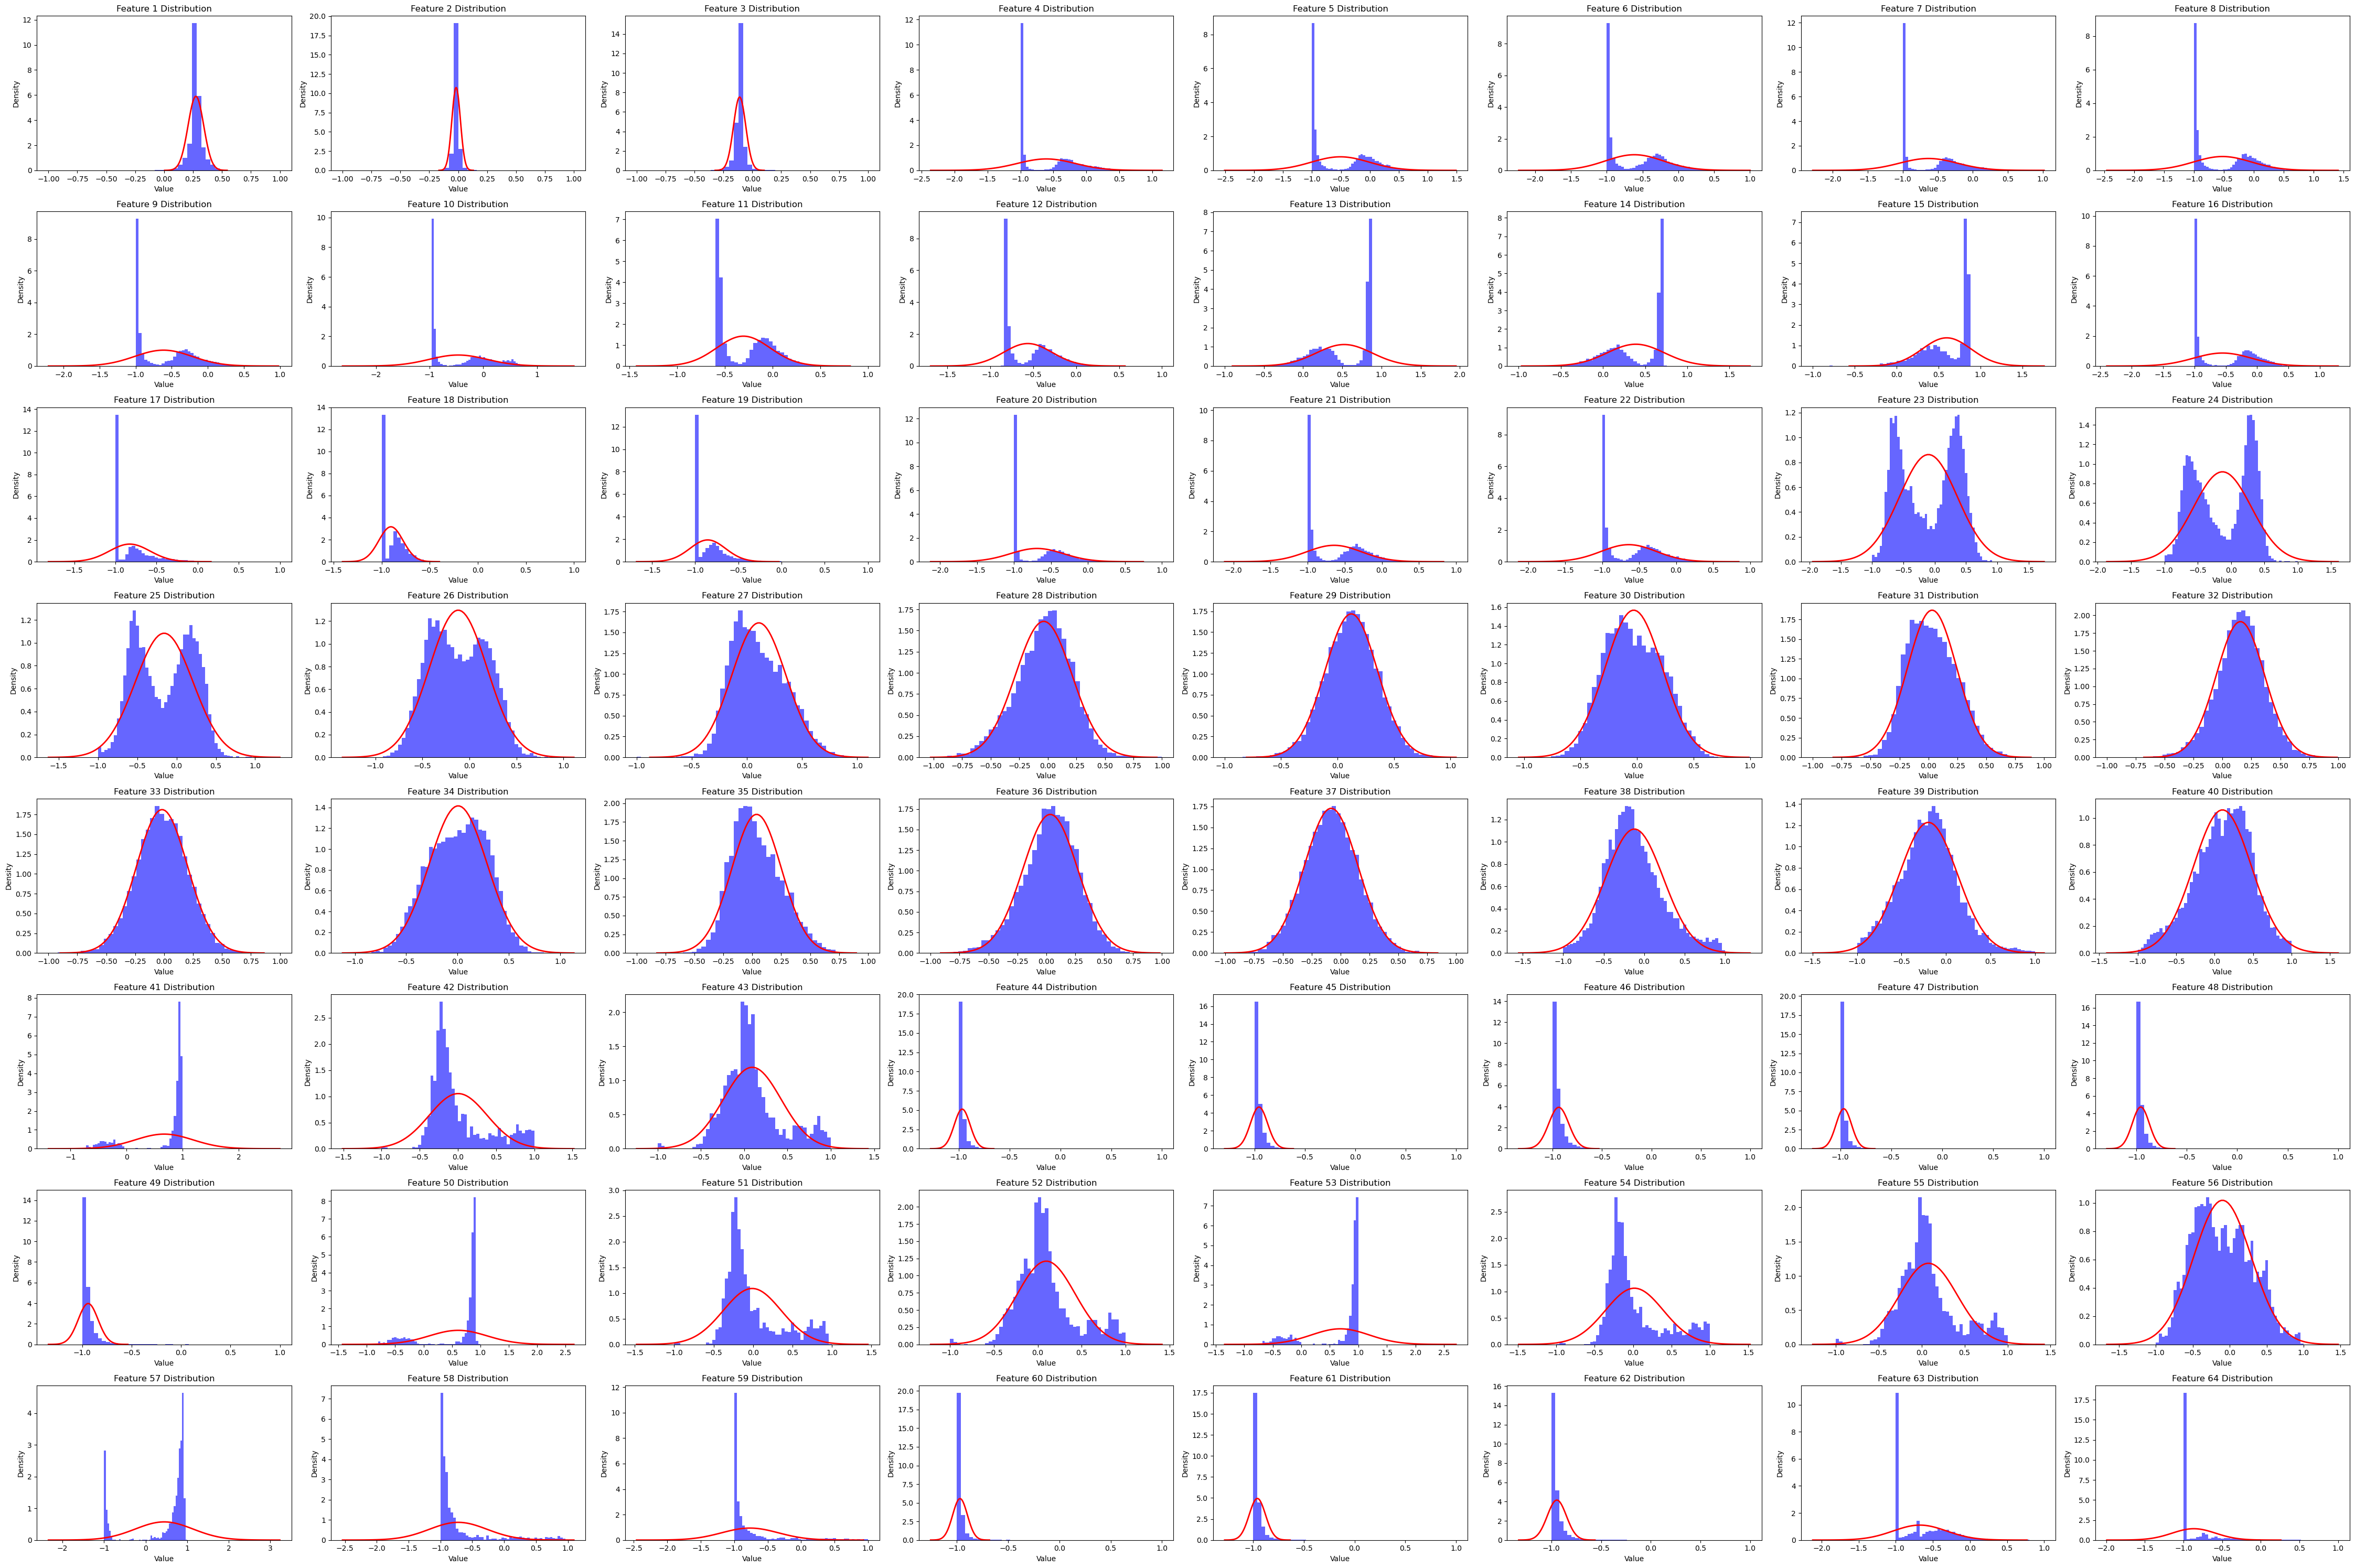

In [7]:
fig, axes = plt.subplots(8, 8, figsize=(45, 30))
axes = axes.ravel()

for idx, ax in enumerate(axes):
    # Select feature
    feature = X[:, idx]

    # Plot histogram
    ax.hist(feature, bins=50, density=True, alpha=0.6, color="b")

    # Add normal distribution curve
    mu = np.mean(feature)
    sigma = np.std(feature)
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
    ax.plot(
        x,
        1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((x - mu) ** 2) / (2 * sigma**2)),
        color="r",
        linewidth=2,
    )

    ax.set_title(f"Feature {idx+1} Distribution")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")

plt.tight_layout()

In [8]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [9]:
y_labels_conversion

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [10]:
n_classes = np.unique(y).size

Scale the sample using StandardScaler with default parameters

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## PCA

In [12]:
pca = PCA(n_components=0.95, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)
X_pca.shape

(10299, 104)

percentage of the variance is covered by the first main component

In [13]:
round(float(pca.explained_variance_ratio_[0] * 100))

51

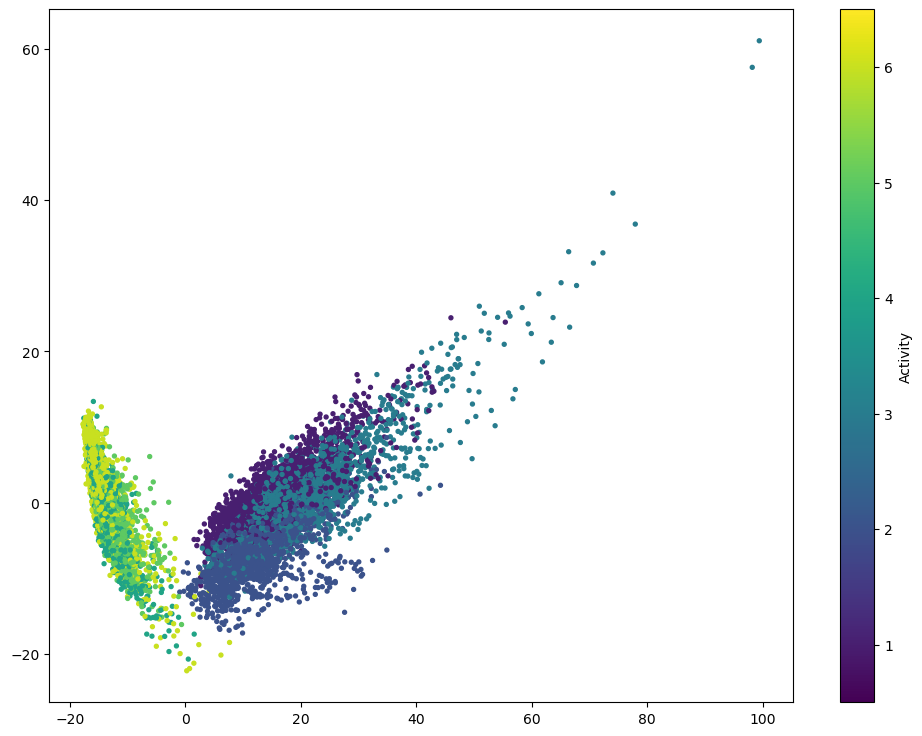

In [14]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=8, cmap="viridis")
plt.colorbar(ticks=range(1, n_classes + 1), label="Activity")
plt.clim(0.5, n_classes + 0.5);

## KMeans

In [15]:
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

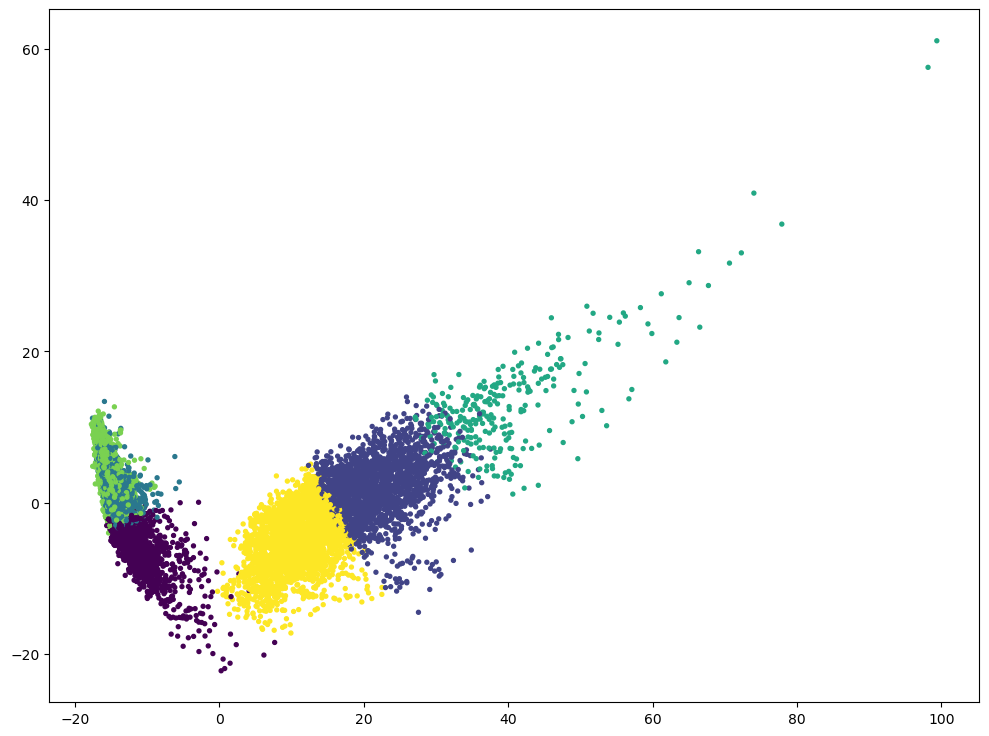

In [16]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=8, cmap="viridis")

In [17]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = [*y_labels_conversion.values(), "all"]
tab.columns = ["cluster" + str(i + 1) for i in range(6)] + ["all"]
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
WALKING,0,742,0,77,0,903,1722
WALKING_UPSTAIRS,2,297,0,5,0,1240,1544
WALKING_DOWNSTAIRS,0,890,0,196,0,320,1406
SITTING,447,0,1238,0,91,1,1777
STANDING,560,0,1346,0,0,0,1906
LAYING,328,0,53,0,1558,5,1944
all,1337,1929,2637,278,1649,2469,10299


In [18]:
pd.Series(
    tab.iloc[:-1, :-1].max(axis=1).values / tab.iloc[:-1, -1].values,
    index=tab.index[:-1],
)

WALKING               0.524390
WALKING_UPSTAIRS      0.803109
WALKING_DOWNSTAIRS    0.633001
SITTING               0.696680
STANDING              0.706191
LAYING                0.801440
dtype: float64

In [19]:
inertia = []
for k in notebook.tqdm(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))


  0%|          | 0/6 [00:00<?, ?it/s]

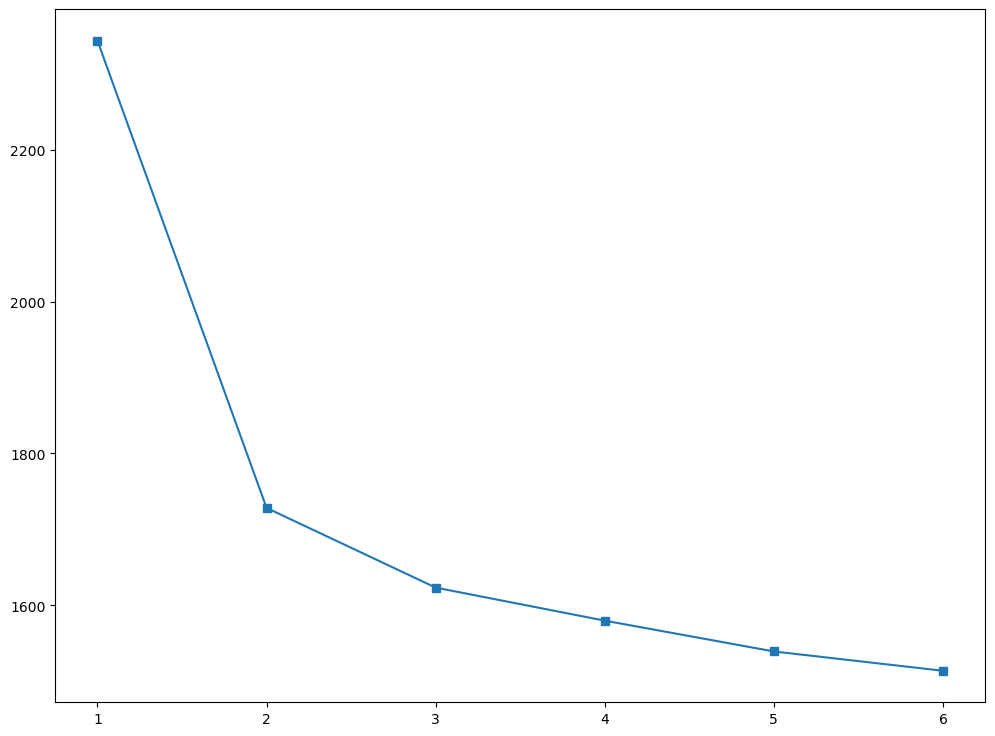

In [20]:
plt.plot(range(1, 7), inertia, marker="s");

In [21]:
d = {}
for k in range(2, 6):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

d

{2: 0.17054006268597527,
 3: 0.41481882386100877,
 4: 0.9322437603301437,
 5: 0.6269417530339366}

##### Only 2 if using KMeans clustering, this suggests it distiguishes only between moving and stationary 

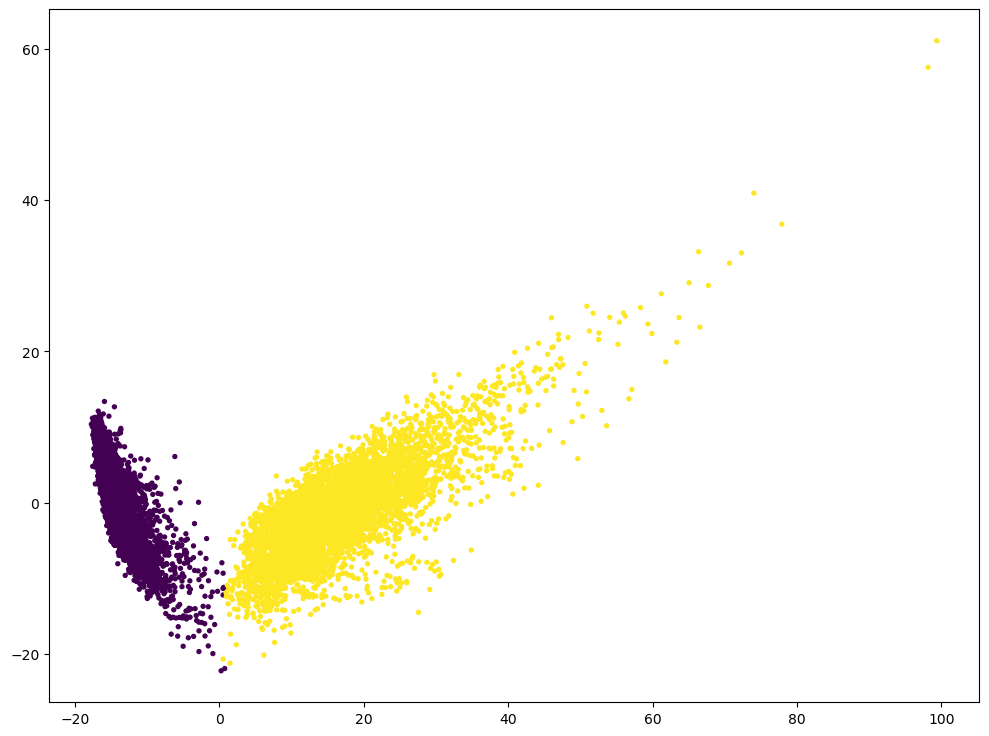

In [22]:
kmeans_new = KMeans(n_clusters=2, n_init=100, random_state=RANDOM_STATE)
kmeans_new.fit(X_pca)
cluster_labels_new = kmeans_new.labels_

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_new, s=8, cmap="viridis")

In [23]:
tab_new = pd.crosstab(y, cluster_labels_new, margins=True)
tab_new.index = [*y_labels_conversion.values(), "all"]
tab_new.columns = ["cluster" + str(i + 1) for i in range(2)] + ["all"]
tab_new

,cluster1,cluster2,all
WALKING,0,1722,1722
WALKING_UPSTAIRS,8,1536,1544
WALKING_DOWNSTAIRS,0,1406,1406
SITTING,1774,3,1777
STANDING,1906,0,1906
LAYING,1932,12,1944
all,5620,4679,10299


## Agglomerative Clustering

In [24]:
ag = AgglomerativeClustering(n_clusters=n_classes, linkage="ward").fit(X_pca)

Text(0.5, 1.0, 'Agglomerative Clustering Results')

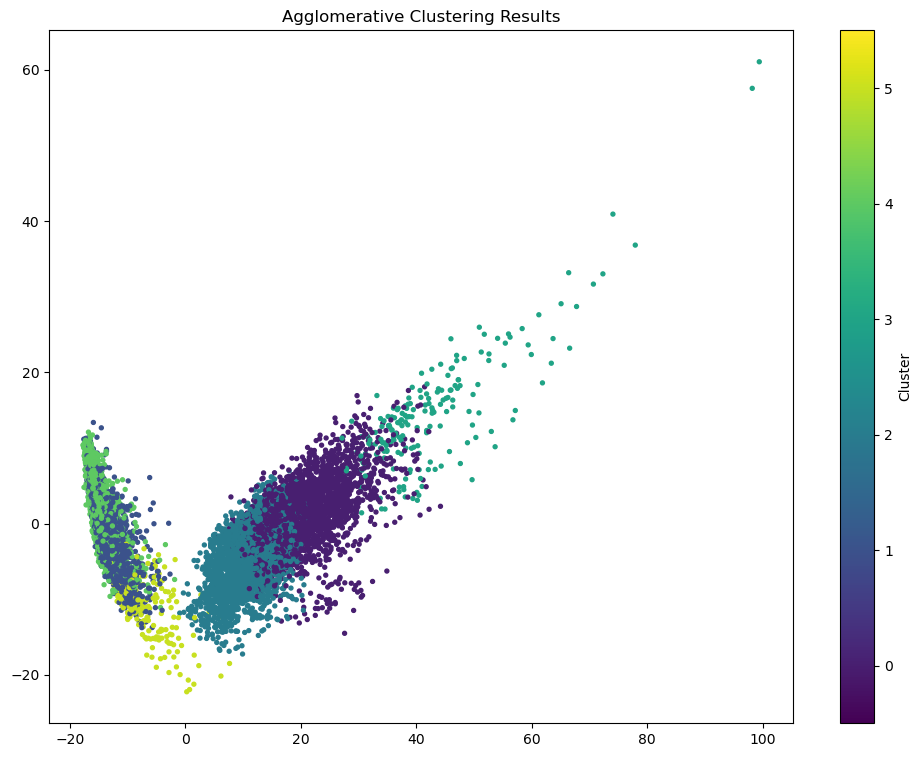

In [25]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=ag.labels_, s=8, cmap="viridis")
plt.colorbar(ticks=range(n_classes), label="Cluster")
plt.clim(-0.5, n_classes - 0.5)
plt.title("Agglomerative Clustering Results")

In [26]:
print("KMeans: ARI =", metrics.adjusted_rand_score(y, cluster_labels))
print("Agglomerative CLustering: ARI =", metrics.adjusted_rand_score(y, ag.labels_))

KMeans: ARI = 0.4198876334592243
Agglomerative CLustering: ARI = 0.5004158813231965


## SVC (Without PCA)

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}


In [29]:
svc.set_params(max_iter=4096)
svc.set_params(dual=True)
best_svc = GridSearchCV(svc, svc_params, n_jobs=-1, cv=3, verbose=1)
best_svc.fit(X_train_scaled, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [30]:
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9382506099134881)

In [31]:
y_predicted = best_svc.predict(X_test_scaled)

In [32]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = [*y_labels_conversion.values(), "all"]
tab.columns = [*y_labels_conversion.values(), "all"]
tab

,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING,all
WALKING,494,2,0,0,0,0,496
WALKING_UPSTAIRS,12,459,0,0,0,0,471
WALKING_DOWNSTAIRS,2,4,413,1,0,0,420
SITTING,0,4,0,426,61,0,491
STANDING,0,0,0,15,517,0,532
LAYING,0,0,0,0,11,526,537
all,508,469,413,442,589,526,2947


## SVC (With PCA)

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [45]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}

In [46]:
svc.set_params(max_iter=8192)
svc.set_params(dual=True)
best_svc_pca = GridSearchCV(svc, svc_params, n_jobs=-1, cv=3, verbose=1)
best_svc_pca.fit(X_train_pca, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [47]:
best_svc_pca.best_params_, best_svc_pca.best_score_

({'C': 0.1}, 0.9192085418418694)